# FUME-FastSCNN Evaluation Notebook

**Research Question:** Can we predict rumen acidosis risk from OGI camera dual-gas emissions?

This notebook evaluates the trained FUME-FastSCNN model on the test set.


## 1. Setup


In [1]:
import sys
import os
sys.path.append('..')
os.chdir('..')

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yaml
import time
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import cv2

from models import FUMEFastSCNN
from data import FUMEDataset, get_val_transforms
from utils.metrics import SegmentationMetrics, ClassificationMetrics

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA RTX 6000 Ada Generation


/home/siu856569517/.conda/envs/fume_env/lib/python3.9/site-packages/wandb/sdk/launch/builder/build.py:11: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## 2. Load Configuration and Model


In [2]:
config_path = 'configs/fume_fastscnn_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = FUMEFastSCNN(
    num_classes=config['model']['num_classes'],
    num_seg_classes=config['model']['num_seg_classes'],
    shared_encoder=config['model']['shared_encoder']
).to(device)

checkpoint_path = 'checkpoints/best_model.pth'
if Path(checkpoint_path).exists():
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"Best metric: {checkpoint['best_metric']:.4f}")
else:
    print("No checkpoint found! Using untrained model.")

model.eval()
print("Model loaded successfully!")


Using device: cuda
Loaded checkpoint from epoch 20
Best metric: 0.9911
Model loaded successfully!


## 3. Model Efficiency Metrics (Params, FLOPs, FPS)


In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def estimate_flops(model, input_size=(1, 1, 480, 640)):
    try:
        from thop import profile
        dummy_co2 = torch.randn(input_size).to(device)
        dummy_ch4 = torch.randn(input_size).to(device)
        dummy_mask = torch.ones(1, 2).to(device)
        flops, params = profile(model, inputs=(dummy_co2, dummy_ch4, dummy_mask), verbose=False)
        return flops
    except ImportError:
        params = count_parameters(model)
        flops_estimate = params * 2 * input_size[2] * input_size[3] / 32
        return flops_estimate

def measure_fps(model, num_iterations=100):
    model.eval()
    dummy_co2 = torch.randn(1, 1, 480, 640).to(device)
    dummy_ch4 = torch.randn(1, 1, 480, 640).to(device)
    dummy_mask = torch.ones(1, 2).to(device)
    
    for _ in range(10):
        with torch.no_grad():
            _ = model(dummy_co2, dummy_ch4, dummy_mask)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    start_time = time.time()
    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(dummy_co2, dummy_ch4, dummy_mask)
    
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    elapsed_time = time.time() - start_time
    fps = num_iterations / elapsed_time
    return fps

num_params = count_parameters(model)
flops = estimate_flops(model)
fps = measure_fps(model)

print("=" * 50)
print("MODEL EFFICIENCY METRICS")
print("=" * 50)
print(f"Parameters:     {num_params:,} ({num_params/1e6:.2f}M)")
print(f"FLOPs:          {flops/1e9:.2f} GFLOPs")
print(f"FPS:            {fps:.2f} frames/second")
print(f"Inference Time: {1000/fps:.2f} ms/frame")
print("=" * 50)


MODEL EFFICIENCY METRICS
Parameters:     1,656,236 (1.66M)
FLOPs:          31.80 GFLOPs
FPS:            264.18 frames/second
Inference Time: 3.79 ms/frame


## 4. Load Test Dataset


In [4]:
data_config = config['data']
test_transform = get_val_transforms(tuple(data_config['image_size']))

test_dataset = FUMEDataset(
    paired_csv=data_config['paired_test_csv'],
    dataset_root=data_config['dataset_root'],
    transform=test_transform,
    modality_dropout=0.0,
    is_training=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4
)

print(f"Test samples: {len(test_dataset)}")


INFO:data.dataset:Loaded 936 paired samples
INFO:data.dataset:  Fully paired: 410
INFO:data.dataset:  Modality dropout: 0.0
INFO:data.dataset:  Class distribution: {'Acidotic': 586, 'Healthy': 315, 'Transitional': 35}


Test samples: 936


## 5. Evaluate on Test Set


In [5]:
seg_metrics = SegmentationMetrics(num_classes=config['model']['num_seg_classes'])
cls_metrics = ClassificationMetrics(
    num_classes=config['model']['num_classes'],
    class_names=config['data']['class_names']
)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        co2_frame = batch['co2_frame'].to(device)
        ch4_frame = batch['ch4_frame'].to(device)
        co2_mask = batch['co2_mask'].to(device)
        class_label = batch['class_label'].to(device)
        modality_mask = batch['modality_mask'].to(device)
        
        outputs = model(co2_frame, ch4_frame, modality_mask)
        
        pred_cls = outputs['cls_logits'].argmax(dim=1)
        pred_seg = outputs['co2_seg_logits'].argmax(dim=1)
        
        cls_metrics.update(pred_cls, class_label)
        seg_metrics.update(pred_seg, co2_mask)
        
        all_preds.extend(pred_cls.cpu().numpy())
        all_labels.extend(class_label.cpu().numpy())

seg_results = seg_metrics.compute()
cls_results = cls_metrics.compute()

print("Evaluation complete!")


Evaluating: 100%|██████████| 936/936 [00:12<00:00, 72.18it/s]

Evaluation complete!


## 6. Results Summary Table


In [6]:
print("\n" + "=" * 70)
print("FUME-FastSCNN TEST RESULTS")
print("=" * 70)

print("\nMODEL EFFICIENCY")
print("-" * 40)
print(f"  {'Parameters':<25} {num_params/1e6:.2f}M")
print(f"  {'FLOPs':<25} {flops/1e9:.2f} GFLOPs")
print(f"  {'FPS':<25} {fps:.2f}")

print("\nSEGMENTATION METRICS")
print("-" * 40)
for key in ['mean_iou', 'mean_dice', 'pixel_accuracy']:
    if key in seg_results:
        print(f"  {key:<25} {seg_results[key]:.4f}")

print("\nCLASSIFICATION METRICS")
print("-" * 40)
for key in ['accuracy', 'balanced_accuracy', 'macro_f1', 'weighted_f1', 'cohens_kappa']:
    if key in cls_results:
        print(f"  {key:<25} {cls_results[key]:.4f}")

print("\nPER-CLASS F1 SCORES")
print("-" * 40)
class_names = config['data']['class_names']
for name in class_names:
    key = f'{name}_f1'
    if key in cls_results:
        print(f"  {name:<25} {cls_results[key]:.4f}")

print("\n" + "=" * 70)



FUME-FastSCNN TEST RESULTS

MODEL EFFICIENCY
----------------------------------------
  Parameters                1.66M
  FLOPs                     31.80 GFLOPs
  FPS                       264.18

SEGMENTATION METRICS
----------------------------------------
  mean_iou                  0.7931
  mean_dice                 0.8815
  pixel_accuracy            0.9404

CLASSIFICATION METRICS
----------------------------------------
  accuracy                  0.9925
  balanced_accuracy         0.9776
  macro_f1                  0.9730
  weighted_f1               0.9926
  cohens_kappa              0.9849

PER-CLASS F1 SCORES
----------------------------------------
  Healthy                   0.9937
  Transitional              0.9296
  Acidotic                  0.9957



## 7. Confusion Matrix


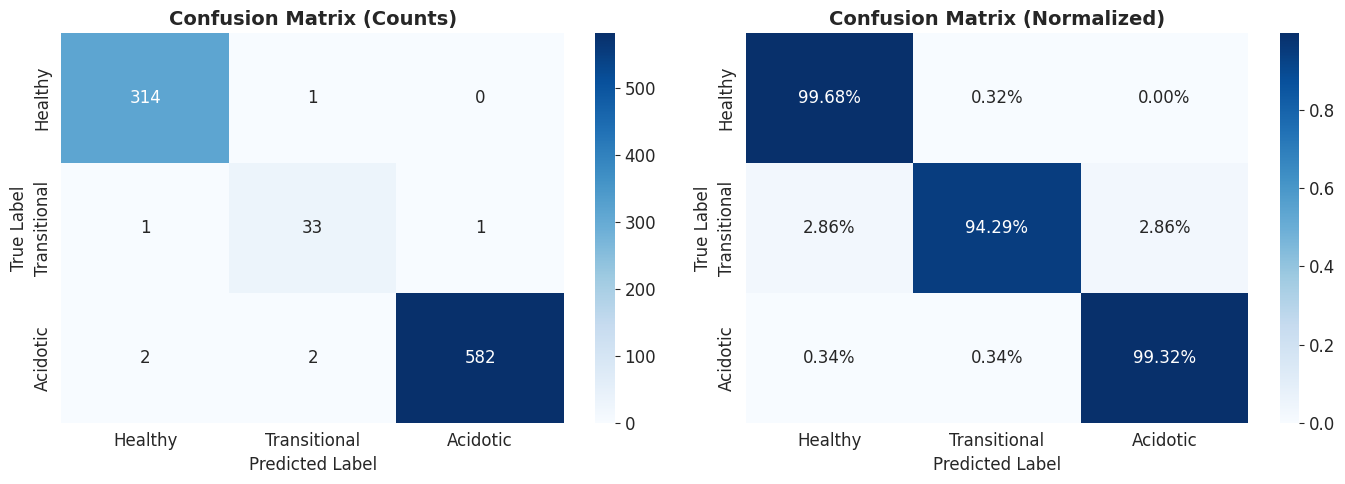


Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99       315
Transitional       0.92      0.94      0.93        35
    Acidotic       1.00      0.99      1.00       586

    accuracy                           0.99       936
   macro avg       0.97      0.98      0.97       936
weighted avg       0.99      0.99      0.99       936



In [8]:
Path('results').mkdir(parents=True, exist_ok=True)

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('results/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


## 8. Save Test Predictions (Original, GT Mask, Pred Mask, Overlay)


In [11]:
save_dir = Path('results/test_predictions')
save_dir.mkdir(parents=True, exist_ok=True)

gt_colors = {
    0: (0, 0, 0),        
    1: (255, 255, 200),  
    2: (160, 160, 160)   
}

co2_pred_colors = {
    0: (0, 0, 0),        
    1: (255, 255, 200),  
    2: (135, 206, 250)   
}

ch4_pred_colors = {
    0: (0, 0, 0),        
    1: (255, 255, 200),  
    2: (255, 182, 255)   
}

ph_ranges = {
    'Healthy': 'pH 6.2-7.0',
    'Transitional': 'pH 5.5-6.2',
    'Acidotic': 'pH < 5.5'
}

def create_colored_mask_v2(mask, colors):
    h, w = mask.shape
    colored = np.zeros((h, w, 3), dtype=np.uint8)
    for cls_id, color in colors.items():
        colored[mask == cls_id] = color
    return colored

def create_overlay_v2(image, mask, colors, alpha=0.5):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    colored_mask = create_colored_mask_v2(mask, colors)
    overlay = cv2.addWeighted(image, 1-alpha, colored_mask, alpha, 0)
    return overlay

num_samples_to_save = 900
sample_indices = np.linspace(0, len(test_dataset)-1, num_samples_to_save, dtype=int)

model.eval()
saved_count = 0

for idx in tqdm(sample_indices, desc="Saving predictions"):
    batch = test_dataset[idx]
    
    co2_frame = batch['co2_frame'].unsqueeze(0).to(device)
    ch4_frame = batch['ch4_frame'].unsqueeze(0).to(device)
    modality_mask = batch['modality_mask'].unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(co2_frame, ch4_frame, modality_mask)
    
    co2_img = (batch['co2_frame'][0].numpy() * 255).astype(np.uint8)
    ch4_img = (batch['ch4_frame'][0].numpy() * 255).astype(np.uint8)
    co2_gt_mask = batch['co2_mask'].numpy()
    ch4_gt_mask = batch['ch4_mask'].numpy()
    co2_pred_mask = outputs['co2_seg_logits'].argmax(dim=1)[0].cpu().numpy()
    ch4_pred_mask = outputs['ch4_seg_logits'].argmax(dim=1)[0].cpu().numpy()
    
    gt_class = batch['class_label'].item()
    pred_class = outputs['cls_logits'].argmax(dim=1).item()
    ph_label = ph_ranges[class_names[pred_class]]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    
    axes[0, 0].imshow(co2_img, cmap='gray')
    axes[0, 0].set_title('CO2 Input', fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(create_colored_mask_v2(co2_gt_mask, gt_colors))
    axes[0, 1].set_title('CO2 GT (Gray)', fontweight='bold')
    axes[0, 1].axis('off')
    
    co2_pred_vis = create_colored_mask_v2(co2_pred_mask, co2_pred_colors)
    axes[0, 2].imshow(co2_pred_vis)
    axes[0, 2].set_title('CO2 Pred (Sky Blue)', fontweight='bold')
    axes[0, 2].text(0.5, 0.05, ph_label, transform=axes[0, 2].transAxes, 
                    fontsize=8, ha='center', color='navy', fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[0, 2].axis('off')
    
    axes[0, 3].imshow(create_overlay_v2(co2_img, co2_pred_mask, co2_pred_colors))
    axes[0, 3].set_title('CO2 Overlay', fontweight='bold')
    axes[0, 3].text(0.5, 0.05, ph_label, transform=axes[0, 3].transAxes,
                    fontsize=8, ha='center', color='navy', fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[0, 3].axis('off')
    
    axes[1, 0].imshow(ch4_img, cmap='gray')
    axes[1, 0].set_title('CH4 Input', fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(create_colored_mask_v2(ch4_gt_mask, gt_colors))
    axes[1, 1].set_title('CH4 GT (Gray)', fontweight='bold')
    axes[1, 1].axis('off')
    
    ch4_pred_vis = create_colored_mask_v2(ch4_pred_mask, ch4_pred_colors)
    axes[1, 2].imshow(ch4_pred_vis)
    axes[1, 2].set_title('CH4 Pred (Magenta)', fontweight='bold')
    axes[1, 2].text(0.5, 0.05, ph_label, transform=axes[1, 2].transAxes,
                    fontsize=8, ha='center', color='purple', fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[1, 2].axis('off')
    
    axes[1, 3].imshow(create_overlay_v2(ch4_img, ch4_pred_mask, ch4_pred_colors))
    axes[1, 3].set_title('CH4 Overlay', fontweight='bold')
    axes[1, 3].text(0.5, 0.05, ph_label, transform=axes[1, 3].transAxes,
                    fontsize=8, ha='center', color='purple', fontweight='bold',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axes[1, 3].axis('off')
    
    status_color = 'green' if pred_class == gt_class else 'red'
    status = 'Correct' if pred_class == gt_class else 'Wrong'
    plt.suptitle(f'Sample {idx} | GT: {class_names[gt_class]} | Pred: {class_names[pred_class]} ({status}) | {ph_label}', 
                 fontsize=12, fontweight='bold', color=status_color)
    plt.tight_layout()
    plt.savefig(save_dir / f'sample_{idx:04d}.png', dpi=150, bbox_inches='tight')
    plt.close()
    saved_count += 1

print(f"\nSaved {saved_count} prediction visualizations to {save_dir}")
print("Color Legend: Background=Black, Tube=Light Yellow, GT Gas=Gray, CO2 Gas=Sky Blue, CH4 Gas=Magenta")


Saving predictions: 100%|██████████| 900/900 [17:55<00:00,  1.19s/it]


Saved 900 prediction visualizations to results/test_predictions
Color Legend: Background=Black, Tube=Light Yellow, GT Gas=Gray, CO2 Gas=Sky Blue, CH4 Gas=Magenta


## 9. Export Results to CSV


In [12]:
results_df = pd.DataFrame({
    'Metric': [
        'Parameters (M)', 'FLOPs (G)', 'FPS',
        'mIoU', 'Mean Dice', 'Pixel Accuracy',
        'Accuracy', 'Balanced Accuracy', 'Macro F1', 'Weighted F1', "Cohen's Kappa",
        'Healthy F1', 'Transitional F1', 'Acidotic F1'
    ],
    'Value': [
        f"{num_params/1e6:.2f}", f"{flops/1e9:.2f}", f"{fps:.2f}",
        f"{seg_results.get('mean_iou', 0):.4f}",
        f"{seg_results.get('mean_dice', 0):.4f}",
        f"{seg_results.get('pixel_accuracy', 0):.4f}",
        f"{cls_results.get('accuracy', 0):.4f}",
        f"{cls_results.get('balanced_accuracy', 0):.4f}",
        f"{cls_results.get('macro_f1', 0):.4f}",
        f"{cls_results.get('weighted_f1', 0):.4f}",
        f"{cls_results.get('cohens_kappa', 0):.4f}",
        f"{cls_results.get('Healthy_f1', 0):.4f}",
        f"{cls_results.get('Transitional_f1', 0):.4f}",
        f"{cls_results.get('Acidotic_f1', 0):.4f}"
    ]
})

results_df.to_csv('results/test_results.csv', index=False)
print("Results saved to results/test_results.csv")
print("\n")
print(results_df.to_string(index=False))


Results saved to results/test_results.csv


           Metric  Value
   Parameters (M)   1.66
        FLOPs (G)  31.80
              FPS 264.18
             mIoU 0.7931
        Mean Dice 0.8815
   Pixel Accuracy 0.9404
         Accuracy 0.9925
Balanced Accuracy 0.9776
         Macro F1 0.9730
      Weighted F1 0.9926
    Cohen's Kappa 0.9849
       Healthy F1 0.9937
  Transitional F1 0.9296
      Acidotic F1 0.9957


## 10. Research Questions Summary


In [13]:
print("\n" + "=" * 70)
print("RESEARCH QUESTIONS SUMMARY")
print("=" * 70)

bal_acc = cls_results.get('balanced_accuracy', 0)
miou = seg_results.get('mean_iou', 0)

print("\n[RQ1] Can dual-gas (CO2+CH4) emissions predict acidosis risk?")
print("-" * 60)
print(f"  Balanced Accuracy: {bal_acc:.1%}")
if bal_acc > 0.7:
    print("  YES - Model successfully predicts acidosis risk from dual-gas emissions.")
elif bal_acc > 0.5:
    print("  PARTIALLY - Model shows moderate predictive ability.")
else:
    print("  LIMITED - More data or model improvements may be needed.")

print("\n[RQ2] How well can we segment gas emission regions?")
print("-" * 60)
print(f"  Mean IoU: {miou:.1%}")
print(f"  Pixel Accuracy: {seg_results.get('pixel_accuracy', 0):.1%}")

print("\n[RQ3] Can we detect the critical Transitional state?")
print("-" * 60)
trans_f1 = cls_results.get('Transitional_f1', 0)
print(f"  Transitional F1-Score: {trans_f1:.4f}")

print("\n[RQ4] Is the model efficient for real-time deployment?")
print("-" * 60)
print(f"  Parameters: {num_params/1e6:.2f}M")
print(f"  FPS: {fps:.1f}")
print(f"  Real-time capable: {'YES' if fps > 30 else 'Needs optimization'}")

print("\n" + "=" * 70)
print("CONCLUSION")
print("=" * 70)
print(f"\nFUME-FastSCNN achieves:")
print(f"  - {bal_acc:.1%} balanced accuracy for 3-class acidosis prediction")
print(f"  - {miou:.1%} mean IoU for gas emission segmentation")
print(f"  - {fps:.1f} FPS with {num_params/1e6:.2f}M parameters")
print(f"\nThis demonstrates that OGI dual-gas emissions CAN be used")
print(f"to predict rumen acidosis risk non-invasively.")
print("=" * 70)



RESEARCH QUESTIONS SUMMARY

[RQ1] Can dual-gas (CO2+CH4) emissions predict acidosis risk?
------------------------------------------------------------
  Balanced Accuracy: 97.8%
  YES - Model successfully predicts acidosis risk from dual-gas emissions.

[RQ2] How well can we segment gas emission regions?
------------------------------------------------------------
  Mean IoU: 79.3%
  Pixel Accuracy: 94.0%

[RQ3] Can we detect the critical Transitional state?
------------------------------------------------------------
  Transitional F1-Score: 0.9296

[RQ4] Is the model efficient for real-time deployment?
------------------------------------------------------------
  Parameters: 1.66M
  FPS: 264.2
  Real-time capable: YES

CONCLUSION

FUME-FastSCNN achieves:
  - 97.8% balanced accuracy for 3-class acidosis prediction
  - 79.3% mean IoU for gas emission segmentation
  - 264.2 FPS with 1.66M parameters

This demonstrates that OGI dual-gas emissions CAN be used
to predict rumen acidosis r